In [22]:
import tifffile as tiff
import numpy as np

path = r"Sinogram.tif"

one_slice = tiff.imread(path)
print(one_slice.shape)

(5600, 2048)


In [ ]:
import tifffile as tiff
import numpy as np

path = r"C:\Users\clement.capdeville\Desktop\dent_test.tif"

projs = tiff.imread(path)

one_slice = projs[:, 500]
print(one_slice.shape)

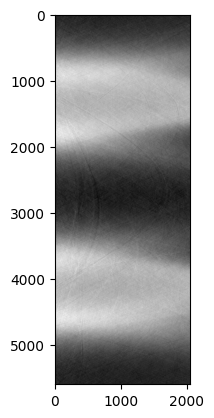

In [23]:
import matplotlib.pyplot as plt
plt.imshow(one_slice, cmap='gray')

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(one_slice, name='one_slice')

In [127]:
### Get angles
import h5py

path = r"D:\test\013_09B0960.nxs"
# path = r"D:\SOLEIL0125\014_xlh_2\014_xlh_2\014_xlh_2.nxs"
# path = r"D:\test\013_09B0960.nxs"

def find_angles_in_dataset(file, nz, group=None, path="", results=None, start_tol=1, end_tol=1):
    """
    Trouve tous les datasets 1D de longueur `nz`, commençant à ~0 et finissant à ~360.
    Retourne également les tableaux de valeurs correspondants.
    """
    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        
        if isinstance(item, h5py.Group):
            find_angles_in_dataset(
                file, nz, group=item, path=current_path, results=results,
                start_tol=start_tol, end_tol=end_tol
            )
        elif isinstance(item, h5py.Dataset):
            if item.ndim == 1 and item.shape[0] == nz:
                try:
                    data = item[()]
                    if (
                        abs(data[0] - 0) <= start_tol and
                        abs(data[-1] - 360) <= end_tol
                    ):
                        results.append(data)
                        print(f"Dataset trouvé : {current_path} avec {data.shape[0]} valeurs")
                except Exception as e:
                    print(f"Erreur lors de la lecture de {current_path} : {e}")
    return results

with h5py.File(path, "r") as f:
    resultats = find_angles_in_dataset(f, nz=5600) #2400 ou 3200
    for data in resultats:
        print(np.radians(data))

angles = np.radians(np.array(resultats)[0])
print(angles.shape)

Dataset trouvé : /flyscan_0001/scan_data/tomo1Rz1 avec 5600 valeurs
[3.32795832e-06 1.12817787e-03 2.25302778e-03 ... 6.29578829e+00
 6.29691314e+00 6.29803799e+00]
(5600,)


In [128]:
### Trouver les paires d'angles ayant une différence de 180°
def find_pairs(angles):
    pairs = []
    for i in range(len(angles)):
        for j in range(i + 1, len(angles)):
            if abs(angles[i] - angles[j]) == np.pi:
                pairs.append((i, j))
    return pairs

def find_opposite_pairs_best_match(angles):
    angles = np.array(angles) % (2 * np.pi)
    N = len(angles)
    sorted_indices = np.argsort(angles)
    sorted_angles = angles[sorted_indices]
    
    pairs = []
    used = set()

    for i in range(N):
        if i in used:
            continue

        ref_angle = (angles[i] + np.pi) % (2 * np.pi)
        # Recherche dans les angles triés l’index du plus proche de ref_angle
        j = np.argmin(np.abs((sorted_angles - ref_angle + np.pi) % (2 * np.pi) - np.pi))
        j_global = sorted_indices[j]

        if j_global != i and j_global not in used:
            pairs.append((i, j_global))
            used.add(i)
            used.add(j_global)

    return pairs



pairs = find_opposite_pairs_best_match(angles)
print(len(pairs))
print(pairs)
angle_pairs = np.array([[angles[i], angles[j]] for i, j in pairs])
print(angle_pairs)

2793
[(0, 2793), (1, 2794), (2, 2795), (3, 2796), (4, 2797), (5, 2798), (6, 2799), (7, 2800), (8, 2801), (9, 2802), (10, 2803), (11, 2804), (12, 2805), (13, 2806), (14, 2807), (15, 2808), (16, 2809), (17, 2810), (18, 2811), (19, 2812), (20, 2813), (21, 2814), (22, 2815), (23, 2816), (24, 2817), (25, 2818), (26, 2819), (27, 2820), (28, 2821), (29, 2822), (30, 2823), (31, 2824), (32, 2825), (33, 2826), (34, 2827), (35, 2828), (36, 2829), (37, 2830), (38, 2831), (39, 2832), (40, 2833), (41, 2834), (42, 2835), (43, 2836), (44, 2837), (45, 2838), (46, 2839), (47, 2840), (48, 2841), (49, 2842), (50, 2843), (51, 2844), (52, 2845), (53, 2846), (54, 2847), (55, 2848), (56, 2849), (57, 2850), (58, 2851), (59, 2852), (60, 2853), (61, 2854), (62, 2855), (63, 2856), (64, 2857), (65, 2858), (66, 2859), (67, 2860), (68, 2861), (69, 2862), (70, 2863), (71, 2864), (72, 2865), (73, 2866), (74, 2867), (75, 2868), (76, 2869), (77, 2870), (78, 2871), (79, 2872), (80, 2873), (81, 2874), (82, 2875), (83, 287

In [143]:
pas  = angle_pairs[1][0] - angle_pairs[2][0]
print(pas)

-0.001124849911984481


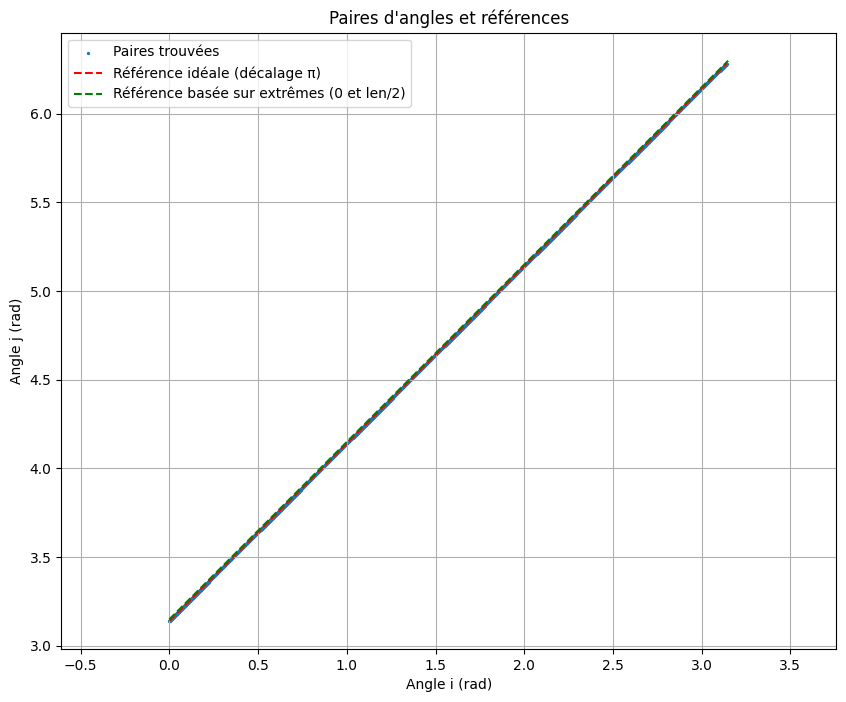

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que tu as :
# angles = [...]  # liste numpy ou liste Python
# pairs = [...]   # liste [(i, j), ...]

# Récupérer les angles appariés
angle_i = np.array([angles[i] for i, j in pairs])
angle_j = np.array([angles[j] for i, j in pairs])

# Scatter plot des paires trouvées
plt.figure(figsize=(10, 8))
plt.scatter(angle_i, angle_j, s=2, label='Paires trouvées')

# Tracer la référence idéale : angle_j = angle_i + π
x_ref = np.linspace(0, np.pi, 100)
y_ref = x_ref + np.pi
plt.plot(x_ref, y_ref, 'r--', label='Référence idéale (décalage π)')

# Tracer la droite passant par les points (angle[0], angle[len//2])
x_alt = np.array([angles[0], angles[len(angles)//2]])
y_alt = np.array([angles[len(angles)//2], angles[-1]])  # Correspondance supposée symétrique
plt.plot(x_alt, y_alt, 'g--', label='Référence basée sur extrêmes (0 et len/2)')

# Affichage
plt.xlabel('Angle i (rad)')
plt.ylabel('Angle j (rad)')
plt.title('Paires d\'angles et références')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()



In [146]:
import cupy as cp
from src.reco_plugin.processing.sinogram import apply_left_weighting, create_sinogram_slice
from tqdm import tqdm

def create_sinogram_slice_from_pairs(proj: cp.ndarray, CoR: int, angle_pairs: list[tuple[int, int]]) -> cp.ndarray:
    """
    Create a sinogram using matched pairs of angles, applying left weighting to both projections.
    Since the first projection is flipped, the weighting becomes symmetrical.
    """
    weights = apply_left_weighting(CoR)
    ny = proj.shape[1]
    sino = cp.zeros((len(angle_pairs), 2 * ny - CoR))

    for k, (i, j) in enumerate(angle_pairs):
        # Projection i (gauche, inversée)
        proj_i = cp.copy(proj[i])
        proj_i[:CoR] *= weights[0]
        flip_i = proj_i[::-1]

        # Projection j (droite), même pondération
        proj_j = cp.copy(proj[j])
        proj_j[:CoR] *= weights[0]

        # Assemble dans sinogramme
        sino[k, :ny] += flip_i
        sino[k, -ny:] += proj_j

    return sino

# start = 200
# stop = 250
# cors_to_test = np.linspace(start, stop, stop - start + 1, dtype=int)
# sinos = []

# max_width = 0

# # D'abord : calculer la plus grande largeur possible
# for CoR in cors_to_test:
#     width = 2 * one_slice.shape[1] - CoR
#     if width > max_width:
#         max_width = width

# # Ensuite : stocker tous les sinogrammes dans un tableau avec padding
# for CoR in tqdm(cors_to_test):
#     # sino = create_sinogram_slice_from_pairs(cp.asarray(one_slice), CoR, pairs).get()
#     sino = create_sinogram_slice(cp.asarray(one_slice), CoR, 1).get()

#     # Padding à droite pour avoir même largeur
#     pad_width = max_width - sino.shape[1]
#     sino_padded = np.pad(sino, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

#     sinos.append(sino_padded)

# # Stack tous les sinogrammes dans un seul tableau 3D
# sinos_array = np.stack(sinos, axis=0)  # (n_CoR, theta, largeur_max)

sino = create_sinogram_slice_from_pairs(cp.asarray(one_slice), 225, pairs).get()

# Affichage dans Napari
viewer = napari.Viewer()
# viewer.add_image(sino1, name='sinograms', colormap='gray')
# viewer.add_image(sinos_array, name='sinograms_from_pairs', colormap='gray')

2792
3.1417091321309747
[3.32795832e-06 1.12817787e-03 2.25302778e-03 ... 3.13833458e+00
 3.13945943e+00 3.14058428e+00]
(2793,)


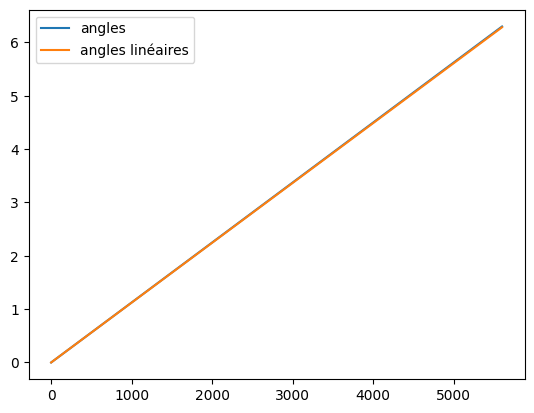

In [137]:
print(pairs[-1][0])
print(angles[pairs[-1][0]+1])
print(angles[:pairs[-1][0]+1])
print(angles[:pairs[-1][0]+1].shape)

plt.plot(angles, label='angles')
plt.plot(np.linspace(0, 2*np.pi, 5600), label='angles linéaires')
plt.legend()

In [147]:
from src.reco_plugin.processing.reconstruction import reconstruct_from_sinogram_slice

reco = reconstruct_from_sinogram_slice(sino, angles[:pairs[-1][0]+1])
reco = np.array(reco)

import napari
viewer = napari.Viewer()
viewer.add_image(reco, name='reco')

<Image layer 'reco' at 0x1cb9a94f350>

In [64]:
angles1 = np.linspace(0, np.pi, sino.shape[0], endpoint=False)
print(angles1.shape)

(2798,)


0.08938232744102761


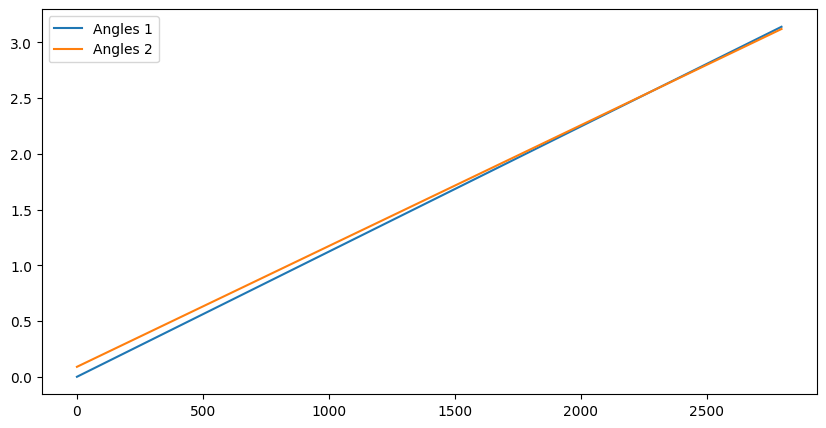

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(angles1, label='Angles 1')
plt.plot(angles[:pairs[-1][0]+1], label='Angles 2')
plt.legend()
print(angles[0])

In [ ]:
def reconstruct(one_slice, angles, center_of_rotation_px, pixel_size, algorithm='FBP_CUDA'):
    """
    Reconstruction d'une tranche à partir des projections avec ASTRA et centre de rotation décalé.
    Padding géré proprement pour éviter les artefacts de bord.
    """
    import astra
    import numpy as np
    import matplotlib.pyplot as plt


    num_proj, det_count = one_slice.shape

    # Décalage réel entre centre de détecteur et centre de rotation ajusté au padding
    shift = -(center_of_rotation_px - det_count / 2)
    print(f"Décalage centre de rotation (avec padding) : {shift}")

    vectors = np.zeros((num_proj, 6), dtype=np.float32)

    for i in range(num_proj):
        theta = angles[i]  # ASTRA = sens horaire

        # 1. Direction du rayon
        ray_x = np.sin(theta)
        ray_y = -np.cos(theta)

        # 2. Centre du détecteur, tournant autour de (shift + center, 0)
        d_x = shift * np.cos(theta)
        d_y = shift * np.sin(theta)

        # 3. Vecteur détecteur (pixel 0 → 1)
        u_x = np.cos(theta)
        u_y = np.sin(theta)

        vectors[i, :] = [ray_x, ray_y, d_x, d_y, u_x, u_y]

    # Création des géométries ASTRA avec padding
    proj_geom = astra.create_proj_geom('parallel_vec', det_count, vectors)
    vol_size = 2 * int(det_count - (center_of_rotation_px ))  # Taille de la reconstruction
    vol_geom = astra.create_vol_geom(vol_size, vol_size)

    # Reconstruction
    proj_id = astra.data2d.create('-sino', proj_geom, one_slice)
    rec_id = astra.data2d.create('-vol', vol_geom, 1)

    cfg = astra.astra_dict(algorithm)
    cfg['ProjectionDataId'] = proj_id
    cfg['ReconstructionDataId'] = rec_id
    cfg['option'] = {'GPUindex': 1}

    alg_id = astra.algorithm.create(cfg)
    iterations = 1000
    astra.algorithm.run(alg_id, iterations)

    reconstruction = astra.data2d.get(rec_id)

    # Nettoyage
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(proj_id)
    astra.data2d.delete(rec_id)

    # Affichage
    plt.figure(figsize=(6, 6))
    plt.imshow(reconstruction * pixel_size * 1e6, cmap='gray')
    plt.title(f"{algorithm} avec {iterations} itérations")
    vmin, vmax = np.percentile(reconstruction, [2, 98])
    plt.clim(vmin, vmax)
    plt.colorbar()
    plt.show()

    return reconstruction * pixel_size * 1e6, iterations

import time
# cor = 625.2901836479407
# cor = 95.9520848504325
# cor = 15
cor = 0.5 * one_slice.shape[1]  # Centre de rotation en pixels
pixel_size = 12e-6
algorithm = 'SIRT_CUDA'
start = time.time()
reconstruction, iterations = reconstruct(one_slice, angles, cor, pixel_size, algorithm=algorithm)
end = time.time()

import tifffile as tiff
tiff.imwrite(r"padding.tiff", reconstruction.astype(np.float32), imagej=True)



In [ ]:
x = np.linspace(0, 1, int(2 * cor)).reshape(1, -1)  # Reshape to 2D array
x = np.repeat(x, 250, axis=0)  # Repeat along the first axis
x = np.pad(x, ((0, 0), (0, int(cor))), mode='edge')  # Pad the array

print(x.shape)

plt.imshow(x, cmap='gray')
plt.axvline(x=2 * cor, color='red', linestyle='--', linewidth=2)
plt.title("Image with Red Line at 2 * cor")
plt.colorbar()
plt.show()

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(reconstruction, name='reconstruction')

In [ ]:
def plot_projection_geometry(angles, center_of_rotation_px, det_count, det_spacing=1.0, vector_scale=20):
    import numpy as np
    import matplotlib.pyplot as plt

    p_x_list, p_y_list = [], []
    d_x_list, d_y_list = [], []
    u_x_list, u_y_list = [], []

    shift = (center_of_rotation_px - det_count / 2) * det_spacing
    cx, cy = shift, 0

    for theta in angles:
        theta = -theta  # ASTRA = sens horaire

         # Rotation autour de (shift, 0)
        cos_t, sin_t = np.cos(theta), np.sin(theta)

        # Direction du rayon
        d_x = cos_t
        d_y = sin_t

        # Centre du détecteur (en rotation autour du point (shift, 0))
        p_x = cx + (-np.sin(theta))
        p_y = cy + ( np.cos(theta))

        # Vecteur détecteur (orthogonal à rayon)
        u_x = -np.sin(theta) * det_spacing
        u_y =  np.cos(theta) * det_spacing

    plt.figure(figsize=(8, 8))
    
    # Trajectoire des centres du détecteur
    plt.plot(p_x_list, p_y_list, 'o', color='orange', label='Centre du détecteur')

    # Vecteurs de direction (rayons)
    plt.quiver(p_x_list, p_y_list,
               [dx * vector_scale for dx in d_x_list],
               [dy * vector_scale for dy in d_y_list],
               color='green', scale=1, angles='xy', scale_units='xy',
               width=0.005, label='Direction du rayon')

    # Vecteurs du détecteur
    plt.quiver(p_x_list, p_y_list,
               u_x_list, u_y_list,
               color='red', scale=1, angles='xy', scale_units='xy',
               width=0.005, label='Vecteur détecteur')

    # Points de référence
    plt.plot(0, 0, 'kx', markersize=10, label='Centre de rotation (0,0)')
    plt.plot([shift], [0], 'ro', markersize=5, label='(shift, 0)')

    plt.axis('equal')
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Géométrie des projections ASTRA')
    plt.legend()
    plt.show()


plot_projection_geometry(angles, center_of_rotation_px=625.2901836479407, det_count=1024)

